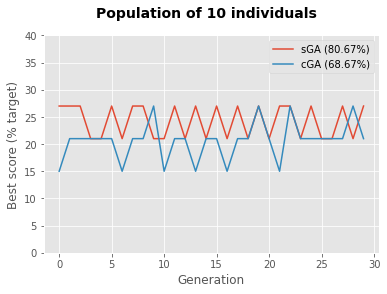

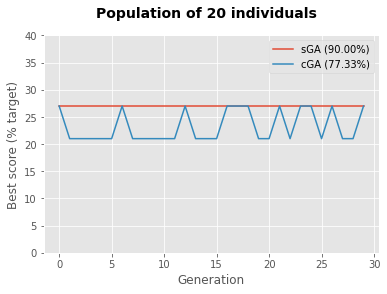

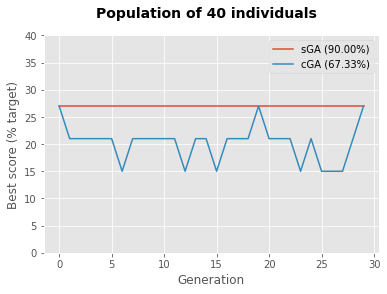

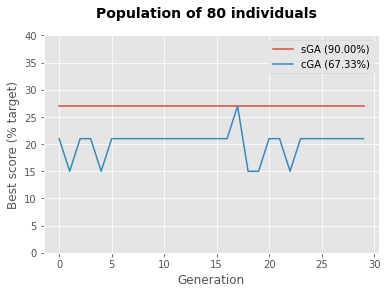

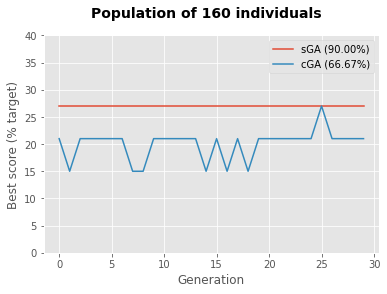

In [6]:
################################################################################
## Imports

from random import random
from pyeasyga import pyeasyga
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

################################################################################
## Common code

# Population sizes
sizes = [10, 20, 40, 80, 160]

# Number of tests
tests = 30

# Fitness of the global solution
global_fitness = 30

# Data
data = [0] * 15

# Define fitness function A (ftrap5)
def ff_a(individual, data=None):
  u = sum(individual)
  if u < 5:
    return 4 - u
  return 5

# Define fitness function B (invftrap5)
def ff_b(individual, data=None):
  u = sum(individual)
  if u > 0:
    return u - 1
  return 5

# Define the main fitness function
def fitness_function(individual, data=None):
  fit_a, fit_b = 0, 0
  for i in [individual[:5], individual[5:10], individual[10:15]]:
    fit_a += ff_a(i, data)
    fit_b += ff_b(i, data)
  return (fit_a, fit_b)

################################################################################
## Simple Genetic Algorithm (sGA)

# Best fitness of each execution
fitness_sga = []

# Sort function: fast non-dominated sort
def nsgaii(population):
  # Initialize the sorted population
  front = [[]]
  # Initialize the set of solutions that are dominated
  s = [[] for i in range(len(population))]
  # Initialize the number of solutions which dominate an individual
  n = [0 for i in range(len(population))]
  # Initialize the rank of solutions
  rank = [0 for i in range(len(population))]
  # Looks for the `p`-dominated solutions and
  # calculates the degree of domination over `p`
  for p in range(len(population)):
    s[p] = []
    n[p] = 0
    # Get `p` fitness
    pfa, pfb = population[p].fitness
    for q in range(len(population)):
      # Get `q` fitness
      qfa, qfb = population[q].fitness
      # Check which dominates which
      if ((pfa > qfa and pfb > qfb) or (pfa >= qfa and pfb > qfb)
        or (pfa > qfa and pfb >= qfb)):
          s[p].append(q)
      elif ((qfa > pfa and qfb > pfb) or (qfa >= pfa and qfb > pfb)
        or (qfa > pfa and qfb >= pfb)):
          n[p] += 1
    # Check if `p` belongs to the fisrt front
    if n[p] == 0:
      rank[p] = 0
      if p not in front[0]:
        front[0].append(p)
  # Initiliaze the front counter
  i = 0
  while front[i] != []:
    aux = []
    for p in front[i]:
      for q in s[p]:
        n[q] = n[q] - 1
        if n[q] == 0:
          rank[q] = i + 1
          if q not in aux:
            aux.append(q)
    i += 1
    front.append(aux)
  # Remove the last set of individuals
  del front[len(front) - 1]
  # Convert to a usual population list
  sorted_pop = []
  for f in front:
    for i in f:
      sorted_pop.append(population[i])
  return sorted_pop

# Set rank population function (now it uses NSGA-II algorithm)
def rank_population(self):
  self.current_generation = nsgaii(self.current_generation)

# Set initial population generation function (fix rank population call)
def create_first_generation(self):
  self.create_initial_population()
  self.calculate_population_fitness()
  self.rank_population(self)


# Set next population generation function (fix rank population call)
def create_next_generation(self):
  self.create_new_population()
  self.calculate_population_fitness()
  self.rank_population(self)

# Set evolution function
def run(self):
  self.create_first_generation(self)
  for _ in range(1, self.generations):
    self.rank_population(self)
    self.create_next_generation(self)

for ps in sizes:
  popfit = []
  for _ in range(tests):
    # Initialize genetic algorithm
    sga = pyeasyga.GeneticAlgorithm(data, population_size=ps)
    # Set fitness function
    sga.fitness_function = fitness_function
    sga.rank_population = rank_population
    sga.create_first_generation = create_first_generation
    sga.create_next_generation = create_next_generation
    sga.run = run
    # Run sGA
    sga.run(sga)
    # Get best individual
    fitness, result = sga.best_individual()
    fa, fb = fitness
    popfit.append(fa + fb)
  fitness_sga.append(popfit)

################################################################################
## Compact Genetic Algorithm (cGA)

# Best fitness of each execution
fitness_cga = []

# Update probability vector
def update_prob(winner, loser, prob, popsize):
  for i in range(0, len(prob)):
    if winner[i] != loser[i]:
      if winner[i] == 1:
        prob[i] += 1.0 / float(popsize)
      else:
        prob[i] -= 1.0 / float(popsize)

# Create a new individual
def create_individual(prob):
  individual = []
  for p in prob:
    if random() < p:
      individual.append(1)
    else:
      individual.append(0)
  return pyeasyga.Chromosome(individual)

# Make competition between two individuals
def compete(a, b):
  pfa, pfb = a.fitness
  qfa, qfb = b.fitness
  if ((pfa > qfa and pfb > qfb) or (pfa >= qfa and pfb > qfb)
    or (pfa > qfa and pfb >= qfb)):
      return a, b
  else:
    return b, a

# Set evolution function
def run(self):
  # Initialize probability vector
  prob = [0.5] * len(self.seed_data)
  # Initialize best solution
  best = None
  # Run `i` generations
  for _ in range(0, self.generations):
    # Create individuals
    a = self.create_individual(prob)
    b = self.create_individual(prob)
    # Calculate fitness for each individual
    a.fitness = self.fitness_function(a.genes)
    b.fitness = self.fitness_function(b.genes)
    # Get the best and worst individual
    winner, loser = compete(a, b)
    # Update best solution
    if best:
      if winner.fitness > best.fitness:
        best = winner
    else:
      best = winner
    # Update the probability vector based on the success of each bit
    update_prob(winner.genes, loser.genes, prob, self.population_size)
  # Add final solution
  self.current_generation.append(best)

for ps in sizes:
  popfit = []
  for _ in range(tests):
    # Initialize genetic algorithm
    cga = pyeasyga.GeneticAlgorithm(data, population_size=ps)
    # Set create individual function
    cga.create_individual = create_individual
    # Set fitness function
    cga.fitness_function = fitness_function
    # Set evolution function
    cga.run = run
    # Run evolution
    cga.run(cga)
    # Get best individual
    fitness, result = cga.best_individual()
    fa, fb = fitness
    popfit.append(fa + fb)
  fitness_cga.append(popfit)

################################################################################
## Plot comparison charts

for i in range(len(sizes)):
  sga_accuracy = 0.0
  for f in fitness_sga[i]:
    sga_accuracy += f / global_fitness
  sga_accuracy /= tests
  cga_accuracy = 0.0
  for f in fitness_cga[i]:
    cga_accuracy += f / global_fitness
  cga_accuracy /= tests
  # Plot
  fig = plt.figure()
  fig.suptitle('Population of ' + str(sizes[i]) + ' individuals',
     fontsize=14, fontweight='bold')
  line_sga, = plt.plot(fitness_sga[i])
  line_cga, = plt.plot(fitness_cga[i])
  plt.ylim(0, 40)
  plt.legend([line_sga, line_cga],
    ['sGA ({:.2f}%)'.format(sga_accuracy*100),
     'cGA ({:.2f}%)'.format(cga_accuracy*100)])
  plt.xlabel('Generation')
  plt.ylabel('Best score (% target)')
  plt.show()

################################################################################